In [25]:
from cryptory import Cryptory

In [26]:
my_cryptory = Cryptory(from_date="2013-04-28")

In [27]:
my_cryptory

<cryptory.cryptory.Cryptory instance at 0x7f91e63bffc8>

In [28]:
# Daily data from coinmarketcap
bitcoin_market_info = my_cryptory.extract_coinmarketcap("bitcoin")
bitcoin_market_info.loc[bitcoin_market_info['date'] == '2018-01-25' ]

,date,open,high,low,close,volume,marketcap
234,2018-01-25,11421.7,11785.7,11057.4,11259.4,8873169920,192162840576


In [29]:
# Daily subscriber numbers to the bitcoin reddit page
# my_cryptory.extract_reddit_metrics(subreddit="bitcoin", metric="total-subscribers")

In [30]:
# Google Trends - bitcoin search results
# my_cryptory.get_google_trends(kw_list=["bitcoin"])

In [31]:
# dow jones price (market code from yahoo finance)
# my_cryptory.get_stock_prices(market="%5EDJI")

In [32]:
# USD/EUR exchange rate
# my_cryptory.get_exchange_rates(from_currency="USD", to_currency="EUR")

In [33]:
# USD/EUR exchange rate
# my_cryptory.get_exchange_rates(from_currency="USD", to_currency="EUR")

In [34]:
# get historical commodity prices
# my_cryptory.get_metal_prices()

KeyError: 'Date'

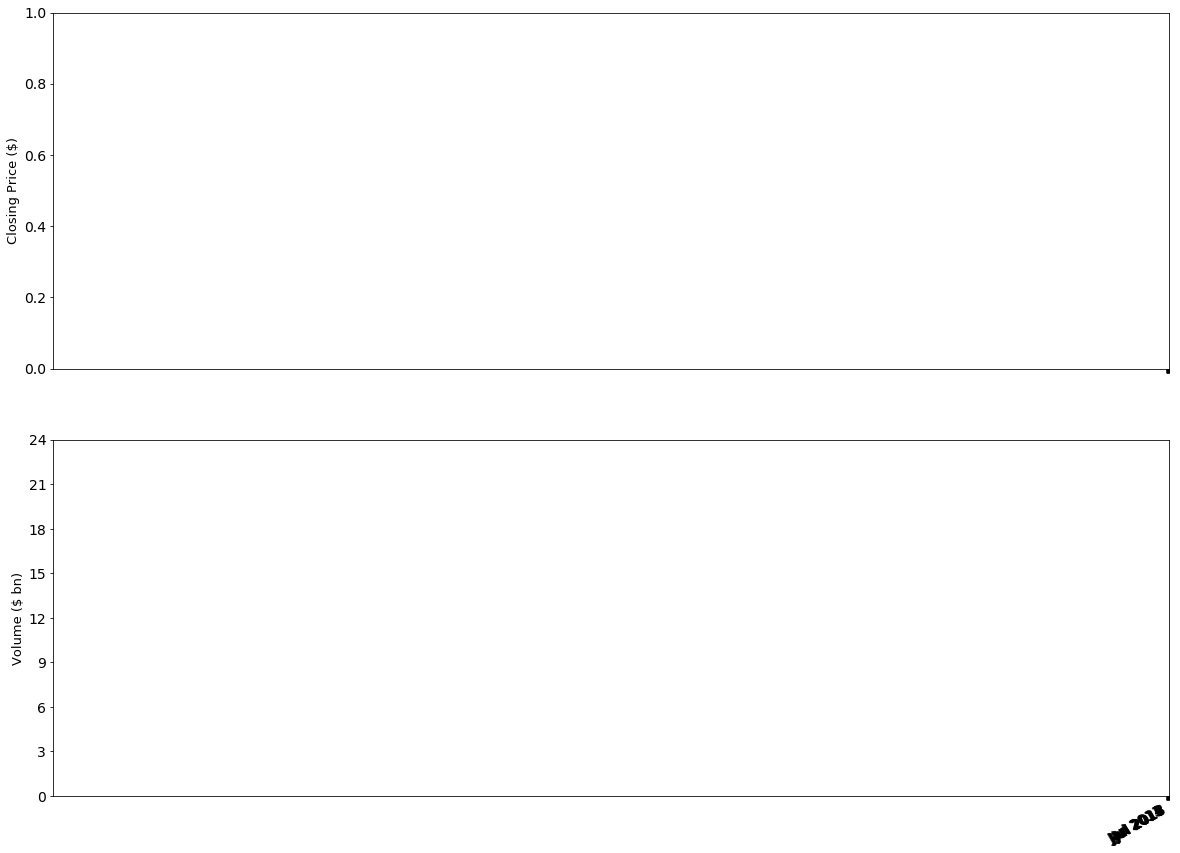

In [228]:
import matplotlib.pyplot as plt
%matplotlib inline  
from matplotlib import rcParams # this module controls the default values for plotting in matplotlib
rcParams['font.size'] = 14
# rcParams['lines.linewidth'] = 4
rcParams['figure.figsize'] = (20, 16)

fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[5, 5]} )
fig.autofmt_xdate()

ax1.set_ylabel('Closing Price ($)',fontsize=13)
ax2.set_ylabel('Volume ($ bn)',fontsize=13)
ax2.set_yticks([int('%d000000000'%i) for i in range(0, 25, 3)])
ax2.set_yticklabels(range(0, 25, 3))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(bitcoin_market_info['Date'].astype(datetime.datetime),bitcoin_market_info['bt_Open'])
ax2.bar(bitcoin_market_info['Date'].astype(datetime.datetime).values, bitcoin_market_info['bt_Volume'].values)
fig.tight_layout()

# print(bitcoin_market_info['bt_Volume'].values.max())
fig.figimage(bitcoin_im, 320, 650, zorder=3, alpha=.6)
plt.plot(subplots=True)
# plt.show()

In [35]:
import seaborn as sns
from cryptory import Cryptory
import datetime
import matplotlib.pyplot as plt
import urllib2 as urllib
import time
import numpy as np
import pandas as pd
from datetime import timedelta
import numpy as np

"""
    Func to make data from blockchain or other sources consistent with btc exchange data
    If data from APIs has data since 2009 we omit those, if no data exist of a date, the previous date value is used
"""
def drop_inititial_rows(api, start_date='2013-04-28'):
    # Read data 
    api_range_format= api+'?timespan=all&format=csv'
#     print(api_range_format)
    data = pd.read_csv(urllib.urlopen(api_range_format))
    
    # Check if its the Block Size data
    if 'avg' in api:
        # Format columns
        data = pd.DataFrame(data.values, columns=['date', 'avg_block_size'])
        data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
        data['date'] = pd.DataFrame(data=data['date'], columns=['date'])

        data['date'] = pd.to_datetime(data['date'])

        # Add dates that do not appear at all, because their blocksize was same as the day before
        data = data.set_index('date').resample('D').ffill()

        # Reset index
        data.index.name='date'
        data = data.reset_index()
        data = data

        # Drop values before 2013, to be consistent with BTC Exchange dataset
        data = data.drop(data[data['date'] < '2013-04-28'].index)
        data = data.reset_index(drop=True)
        return data
        
    elif 'transactions' in api:
        # Get the average block size from blockchain.info; max size ==> 1 MB (by design)
        df = data
        df = pd.DataFrame(df.values, columns=['date', 'transactions'])
        df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
        df['date'] = pd.DataFrame(data=df['date'], columns=['date'])
        df['date']=df
        df['date'] = pd.to_datetime(df['date'])
        # Remove rows corresponding to dates before 2013-05-02
        df = df.set_index('date').resample('D').ffill()
        df.index.name='date'
        df.index.names = ['date']
        data = df.reset_index()
        df = data
        df[df['date'] < start_date]

        df = df.drop(df[df['date'] < start_date].index)
        df = df.reset_index(drop=True)
        return df

In [36]:
def rename_columns(prepend_to_name, df):
    df.columns = [df.columns[0]]+ \
                [str(prepend_to_name)+i for i in df.columns[1:]]

In [37]:
####################################################################################################################
######## Getting Blockchain data
####################################################################################################################

# Get the average block size from blockchain.info; max size ==> 1 MB (by design)
block_size_api = "https://blockchain.info/charts/avg-block-size" 
avg_block_size = drop_inititial_rows(block_size_api)

# Get transactions Daily
txs_api = "https://api.blockchain.info/charts/n-transactions" 
txs = drop_inititial_rows(txs_api)

In [198]:
####################################################################################################################
######## Getting Exchange Data, Sentiment Data (Reddit & Google Trends), Fin. Indecies (Yahoo), USD & EUR Exchanges
####################################################################################################################
my_cryptory = Cryptory(from_date="2013-04-28")

btc_market_info = my_cryptory.extract_coinmarketcap('bitcoin')
btc_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(btc_market_info['date']))
print(type(btc_market_info.volume))
pd.DataFrame(btc_market_info).fillna(btc_market_info.mean())
print((btc_market_info == np.nan).any())
# convert to int
btc_market_info['volume'] = btc_market_info['volume'].astype('int64')
# sometime after publication of the blog, coinmarketcap starting returning asterisks in the column names
# this will remove those asterisks
btc_market_info.columns = btc_market_info.columns.str.replace("*", "")
# [['date','close','volume','open', 'high', 'how', 'Market Cap']]
btc_market_info = btc_market_info.assign(Date=pd.to_datetime(btc_market_info['date']))
rename_columns('bt_', btc_market_info)

# Calculate new columns
for coins in ['bt_']: 
    kwargs = { coins+'day_diff': lambda x: (x[coins+'close']-x[coins+'open'])/x[coins+'open']}
    btc_market_info = btc_market_info.assign(**kwargs)

for coins in ['bt_']: 
    kwargs = { coins+'close_off_high': lambda x: 2*(x[coins+'high']- x[coins+'close'])/(x[coins+'high']-x[coins+'low'])-1,
            coins+'volatility': lambda x: (x[coins+'high']- x[coins+'low'])/(x[coins+'open'])}
    btc_market_info = btc_market_info.assign(**kwargs)

btc_final = btc_market_info
btc_final.to_csv('btc_data_reconciliation.csv')

# # Get volume, and rest of data

# btc_google_trends = my_cryptory.get_google_trends(kw_list=['bitcoin'])
# rename_columns('google_trends_', btc_google_trends)

# Leave our reddit for now
# btc_reddit_subscribers = my_cryptory.extract_reddit_metrics(subreddit="bitcoin", 
#                                          metric="total-subscribers")
# rename_columns('reddit_', btc_reddit_subscribers)

# Dow Jones price (market code)
# dow_jones_stock = my_cryptory.get_stock_prices(market="%5EDJI")
# print(dow_jones_stock)
# Testing purposes
# dow_jones_stock = dow_jones_stock.loc[:,['date', 'close']]

# # # Exchange rates
# eur_usd_exchange_rate = my_cryptory.get_exchange_rates(from_currency="USD", to_currency="EUR")

# # Left out reddit
# # btc_final = btc_market_info.merge(btc_google_trends, on='date', how='inner').merge(btc_reddit_subscribers,on='date', how='inner'). \
# #             merge(dow_jones_stock,on='date' ,how='inner'). \
# #             merge(eur_usd_exchange_rate, on='date', how='inner'). \
# #             merge(avg_block_size, on='date', how='inner')

# Get rid of columns we only needed for calculating 'close_off_high' and 'volatility'
btc_final = btc_final[['date']+[coin+metric for coin in ['bt_'] 
                                   for metric in ['close','volume','close_off_high','volatility']]]


# need to reverse the data frame so that subsequent rows represent later timepoints
btc_final = btc_final.sort_values(by='date')
# # Alternatively, we could have scaled with scikit
from sklearn.preprocessing import minmax_scale
import numpy as np
from sklearn.preprocessing import Imputer

mean_imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)

btc_without_date = btc_final.loc[:, btc_final.columns != 'date']

# Train the imputor on the df dataset
mean_imputer = mean_imputer.fit(btc_without_date)

# Apply the imputer to the df dataset
imputed_df = mean_imputer.transform(btc_without_date)

# Get back columns
imputed_df = pd.DataFrame(imputed_df, columns = btc_without_date.columns)

imputed_df[['bt_close','bt_volume','bt_close_off_high','bt_volatility']] = \
                minmax_scale(imputed_df[[ 'bt_close','bt_volume','bt_close_off_high','bt_volatility' ]])

# Re add date column
imputed_df['date'] = btc_final['date']

# Order by date
imputed_df["date"] = imputed_df["date"].values[::-1]

btc_final=imputed_df
# print(imputed_df)
# cols = imputed_df.columns.tolist()
# # Move 'date' column to first column
# cols = cols[-1:] + cols[:-1]
# # Apply change
# imputed_df = imputed_df[cols]

# # Need to scale columns (min-max scaling)
# btc_final[['google_trends_bitcoin','bt_close', 'bt_volume', 'reddit_total_subscribers', 'adjclose', 'exch_rate', 'avg_block_size']] = (
#         btc_final[['google_trends_bitcoin', 'bt_close', 'bt_volume', 'reddit_total_subscribers', 'adjclose', 'exch_rate', 'avg_block_size']]- \
#         btc_final[['google_trends_bitcoin', 'bt_close', 'bt_volume', 'reddit_total_subscribers', 'adjclose', 'exch_rate', 'avg_block_size']].min())/(
#         btc_final[['google_trends_bitcoin', 'bt_close', 'bt_volume', 'reddit_total_subscribers', 'adjclose', 'exch_rate', 'avg_block_size']].max()- \
#         btc_final[['google_trends_bitcoin', 'bt_close', 'bt_volume', 'reddit_total_subscribers', 'adjclose', 'exch_rate', 'avg_block_size']].min())

<class 'pandas.core.series.Series'>
date          True
open         False
high         False
low          False
close        False
volume       False
marketcap    False
Date          True
dtype: bool


In [203]:
# Get rid of rows where volume is 0
btc_final = btc_final[btc_final['bt_volume']!=0]
# Reindex, starting from 0 
btc_final.index = range(len(btc_final))
# btc_final.reset_index(drop=True)
print(btc_final)

      bt_close  bt_volume  bt_close_off_high  bt_volatility       date
0     0.034312   0.001966           0.664059       0.170651 2013-12-27
1     0.033939   0.001363           0.461041       0.115191 2013-12-28
2     0.034825   0.000797           0.104185       0.095655 2013-12-29
3     0.035396   0.000869           0.397193       0.072468 2013-12-30
4     0.035286   0.000877           0.293173       0.060071 2013-12-31
5     0.036182   0.000943           0.193817       0.055017 2014-01-01
6     0.037777   0.001614           0.337476       0.139924 2014-01-02
7     0.038617   0.001586           0.342660       0.114312 2014-01-03
8     0.040717   0.001594           0.000000       0.143189 2014-01-04
9     0.044526   0.003058           0.192787       0.232355 2014-01-05
10    0.045543   0.003589           0.572929       0.242576 2014-01-06
11    0.037757   0.003411           1.000000       0.352583 2014-01-07
12    0.039852   0.003111           0.295873       0.241962 2014-01-08
13    

In [237]:
split_date = '2018-01-01' # Therefore, the test dataset has values from 2018-01-03 to 2018-09-13

# we don't need the date columns anymore
training_set, test_set = btc_final[btc_final['date']<split_date], btc_final[btc_final['date']>=split_date]
training_set = training_set.drop('date', 1)
print(test_set)
test_set = test_set.drop('date', 1)


      bt_close  bt_volume  bt_close_off_high  bt_volatility       date
1466  0.699408   0.431662           0.475196       0.138282 2018-01-01
1467  0.767600   0.706626           0.202762       0.341202 2018-01-02
1468  0.778866   0.707687           0.510504       0.099100 2018-01-03
1469  0.799361   0.913690           0.115400       0.162492 2018-01-04
1470  0.893566   1.000000           0.110174       0.329524 2018-01-05
1471  0.898584   0.768201           0.195611       0.110622 2018-01-06
1472  0.844572   0.665495           0.738655       0.173479 2018-01-07
1473  0.777276   0.772366           0.587114       0.288181 2018-01-08
1474  0.747696   0.698799           0.840335       0.144666 2018-01-09
1475  0.767147   0.776011           0.000000       0.179116 2018-01-10
1476  0.686468   0.693518           0.843222       0.260463 2018-01-11
1477  0.716053   0.506092           0.232599       0.162364 2018-01-12
1478  0.735591   0.535366           0.423278       0.103289 2018-01-13
1479  

In [238]:
window_len = 100
norm_cols = ['bt_close','bt_volume']
print(norm_cols)

['bt_close', 'bt_volume']


In [239]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['bt_close'][window_len:].values/training_set['bt_close'][:-window_len].values)-1

In [240]:
print(LSTM_training_outputs)

[-0.41187147 -0.42221717 -0.43149774 ...  2.80135348  2.61638518
  2.95477322]


In [241]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['bt_close'][window_len:].values/test_set['bt_close'][:-window_len].values)-1
print(LSTM_test_outputs)

[-4.92235868e-01 -4.75593868e-01 -4.82736244e-01 -4.90185612e-01
 -5.24183705e-01 -5.42331359e-01 -5.22604739e-01 -4.63967230e-01
 -4.33751154e-01 -4.11105229e-01 -3.38164121e-01 -3.72202180e-01
 -3.79891364e-01 -2.97331279e-01 -3.61713778e-01 -1.93396644e-01
 -1.97978088e-01 -1.86422267e-01 -1.89646043e-01 -2.85146566e-01
 -2.15154440e-01 -1.56078862e-01 -1.04124363e-01 -1.46899691e-01
 -1.25212560e-01 -1.36594082e-01 -1.81818582e-01 -2.17742644e-01
 -1.75563348e-01 -1.05835202e-01 -1.75284925e-01 -7.31313948e-02
 -1.21896941e-02 -5.03070341e-02  2.84300086e-02  2.05255240e-01
  4.42803852e-02  8.33683090e-02 -2.24589980e-03 -2.58093914e-02
 -2.37225360e-02 -1.09395971e-02 -1.54518894e-01 -1.18521011e-01
 -2.13711782e-01 -2.78325248e-01 -2.81903345e-01 -3.60069973e-01
 -2.93723297e-01 -3.42280586e-01 -3.44899592e-01 -2.96456307e-01
 -2.37662493e-01 -2.52216675e-01 -2.35883522e-01 -2.11640945e-01
 -2.63415117e-01 -2.85944580e-01 -2.68453270e-01 -3.14173950e-01
 -3.90306018e-01 -4.01249

In [242]:
# I find it easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [243]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()
    
    print(inputs.shape[1])
    print(inputs.shape[2])
    
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
# random seed for reproducibility
np.random.seed(100)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 100
# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['bt_close'])-pred_range):
    LSTM_training_outputs.append((training_set['bt_close'][i:i+pred_range].values/
                                  training_set['bt_close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
bt_history = bt_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

100
4
Epoch 1/50
 - 81s - loss: 0.4068
Epoch 2/50


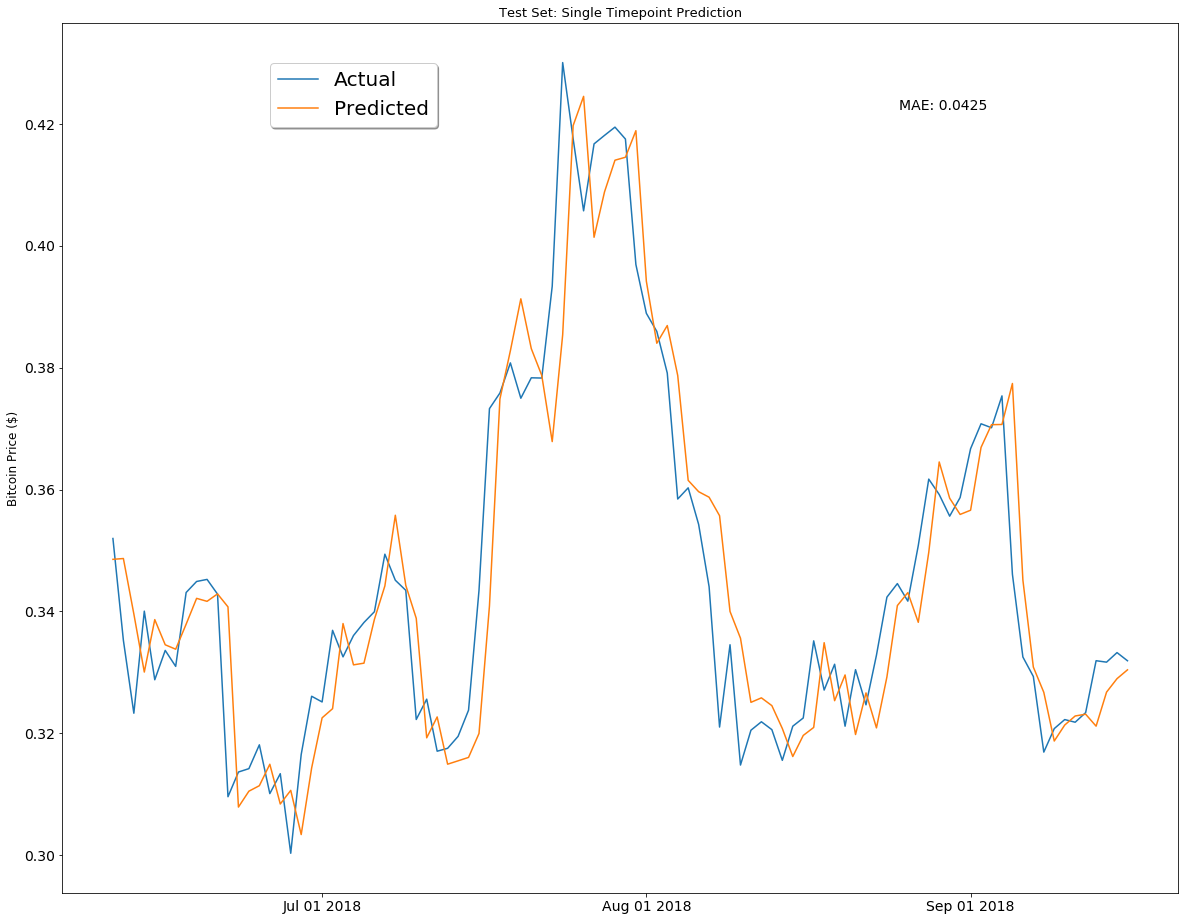

In [232]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(btc_final[btc_final['date']>= split_date]['date'][window_len:].astype(datetime.datetime),
         test_set['bt_close'][window_len:], label='Actual')
ax1.plot(btc_final[btc_final['date']>= split_date]['date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_test_inputs))+1) * test_set['bt_close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_test_inputs))+1)-\
            (test_set['bt_close'].values[window_len:])/(test_set['bt_close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=2, prop={'size': 20}, shadow=True)
plt.show()

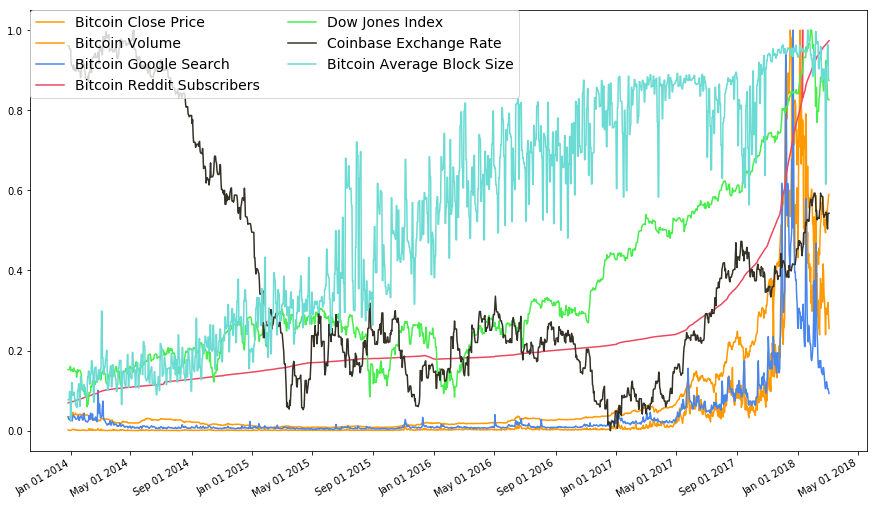

In [25]:
%matplotlib inline
fig, ax1 = plt.subplots(1, 1, figsize=(15, 9)) # 1 row 1 col

fig.autofmt_xdate()

ax1.set_xticks([datetime.date(j,i,1) for i in range(1,13,4) for j in range(2013,2019)])
ax1.set_xticklabels([datetime.date(j,i,1).strftime('%b %d %Y') 
                     for i in range(1,13,4) for j in range(2013,2019)])

ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['bt_close'], label='Bitcoin Close Price', color='#FF9900')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['bt_volume'], label='Bitcoin Volume', color='#FF9900')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['google_trends_bitcoin'], label="Bitcoin Google Search", color='#4885ed')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['reddit_total_subscribers'], label="Bitcoin Reddit Subscribers", color='#ed475e')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['adjclose'], label="Dow Jones Index", color='#47ed4c')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['exch_rate'], label="Coinbase Exchange Rate", color='#353127')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['avg_block_size'], label="Bitcoin Average Block Size", color='#6bdbd3')

ax1.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0., ncol=2, prop={'size': 14})
plt.show()

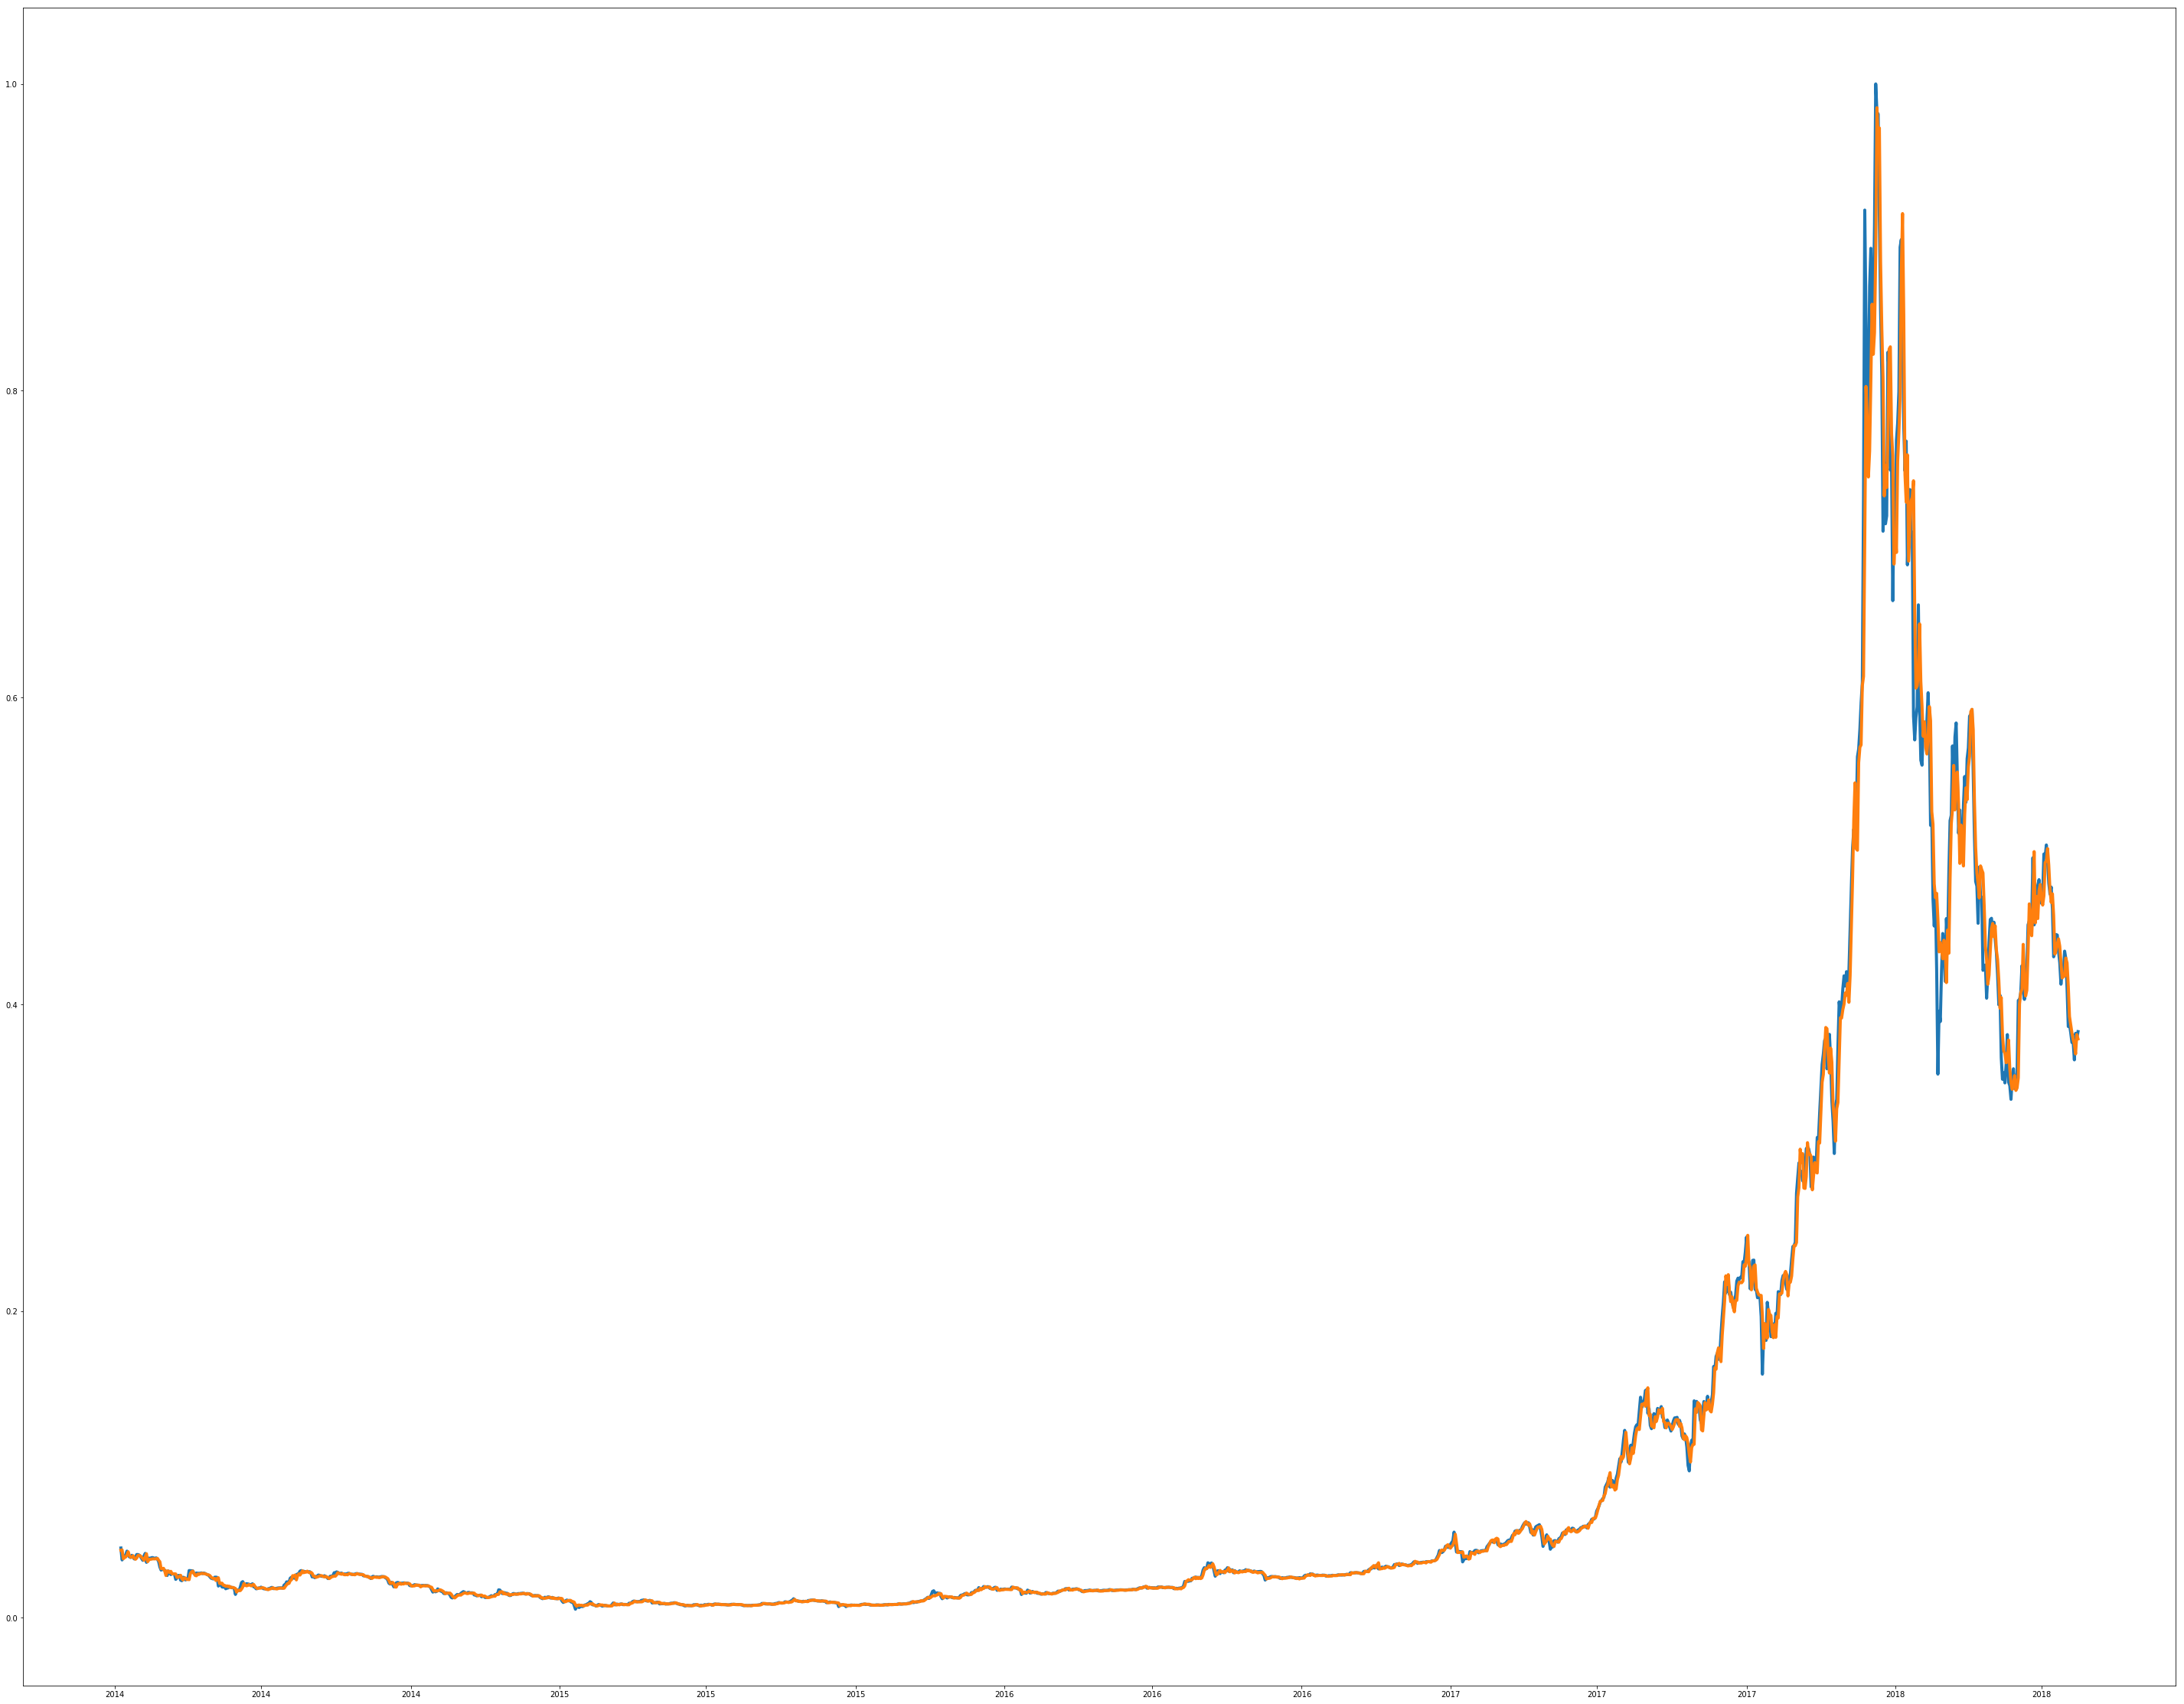

In [236]:
%matplotlib inline
from matplotlib import rcParams # this module controls the default values for plotting in matplotlib
rcParams['font.size'] = 10
rcParams['lines.linewidth'] = 4
rcParams['figure.figsize'] = (20, 16)
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2014,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2014,2019) for j in [1,5,9]])
ax1.plot(btc_final[btc_final['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         training_set['bt_close'][window_len:], label='Actual')
ax1.plot(btc_final[btc_final['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_training_inputs))+1)-\
            (training_set['bt_close'].values[window_len:])/(training_set['bt_close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=2, prop={'size': 20}, shadow=True)
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 2.52, loc=10, bbox_to_anchor=(400, 307)) # zoom-factor: 2.52, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
axins.plot(btc_final[btc_final['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         training_set['bt_close'][window_len:], label='Actual')
axins.plot(btc_final[btc_final['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_close'].values[:-window_len])[0], 
         label='Predicted')
# axins.set_xlim([datetime.date(2017, 2, 15), datetime.date(2017, 5, 1)])
# axins.set_ylim([920, 1400])
# mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()

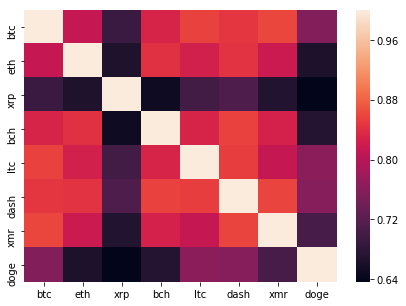

In [21]:
# Pearson correlation on all data sources
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

my_cryptory = Cryptory(from_date="2018-01-01")
all_coins_df = my_cryptory.extract_bitinfocharts("btc")
# coins of interest
bitinfocoins = ["btc", "eth", "xrp", "bch", "ltc", "dash", "xmr", "doge"]
for coin in bitinfocoins[1:]:
    all_coins_df = all_coins_df.merge(my_cryptory.extract_bitinfocharts(coin), on="date", how="left")
# date column not need for upcoming calculations
all_coins_df = all_coins_df.drop('date', axis=1)
# Percentage change => 
# first calculate: Increase = y_t - y_(t-1) then calculate: %Increace = (Increase-y_(t-1))*100
"""
    %Increase is used both to track the prices of individual securities and 
    of large market indexes, as well as comparing the values of different currencies.  
    Balance sheets with comparative financial statements will generally include the 
    prices of specific assets at different points in time along with the percentage 
    changes over the accompanying periods of time.  
"""
# Compute pairwise correlation of columns, excluding NA/null values
corr = all_coins_df.pct_change().corr(method='pearson')
fig, ax = plt.subplots(figsize=(7,5))  
sns.heatmap(corr, 
            xticklabels=[col.replace("_price", "") for col in corr.columns.values],
            yticklabels=[col.replace("_price", "") for col in corr.columns.values],
            annot_kws={"size": 16})
plt.show()

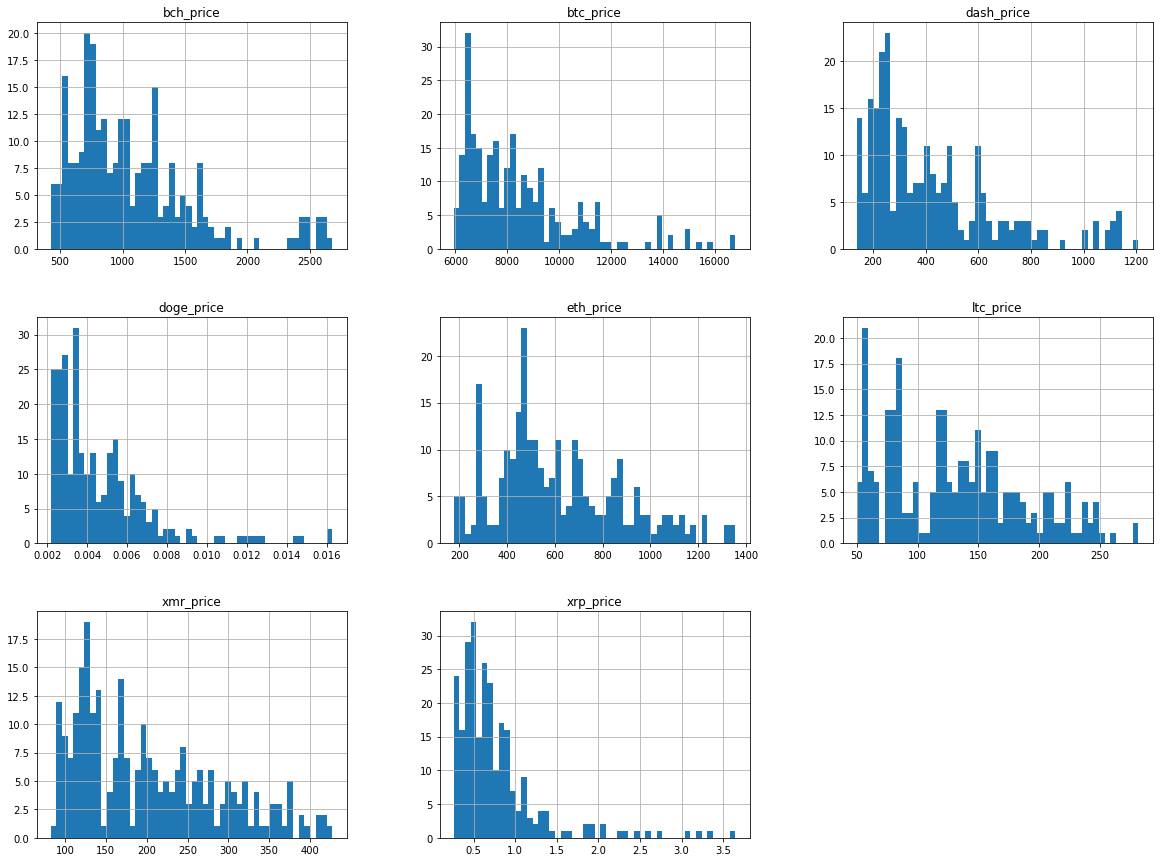

In [22]:
import matplotlib.pyplot as plt
all_coins_df.hist(bins=50, figsize=(20,15))
# print(all_coins_df)
plt.show()